In [1]:
# for dl modeling
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn

# for data processing
import pandas as pd

# for numerical processing
import numpy as np
import scipy.stats as stats

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read in data
df = pd.read_csv("data\winequality-red.csv", sep=";")
print(df.shape)

(1599, 12)


In [3]:
# remove outliers
df = df[df["total sulfur dioxide"] < 200]

# Data normalization zscore all cols except quality
cols2train = df.keys()
cols2train = cols2train.drop("quality")
for col in cols2train:
    df[col] = stats.zscore(df[col])

# converting to binary classification
df["quality"] = df["quality"].apply(lambda x: 1 if x >= 6 else 0)

# organise data
data = torch.tensor(df[cols2train].values).float()
labels = torch.tensor(df["quality"].values).float()
# making the labels 2D
labels = labels.unsqueeze(1)

# train test split
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=42
)
print("train data shape: ", train_data.shape)
print("test data shape: ", test_data.shape)

train data shape:  torch.Size([1277, 11])
test data shape:  torch.Size([320, 11])


In [4]:
# making train and test datasets
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# making dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

print("train loader length: ", len(train_loader))
print("test loader length: ", len(test_loader))
print("train loader batch size: ", train_loader.batch_size)
print("test loader batch size: ", test_loader.batch_size)

train loader length:  39
test loader length:  1
train loader batch size:  32
test loader batch size:  320


In [5]:
# ANN model
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim, actFunName):
        super().__init__()
        self.input = nn.Linear(input_dim, 32)
        self.bnorm32 = nn.BatchNorm1d(32)
        self.fc1 = nn.Linear(32, 64)
        self.bnorm64 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, output_dim)
        self.actFun = getattr(torch.nn, actFunName)()

    def forward(self, x):
        x = self.actFun(self.input(x))
        x = self.bnorm32(x)
        x = self.actFun(self.fc1(x))
        x = self.bnorm64(x)
        x = self.actFun(self.fc2(x))
        x = self.bnorm32(x)
        x = self.output(x)
        return x

In [6]:
# test the model
model = ANN(train_data.shape[1], 1, "ReLU")
print(model)
model( torch.randn(10,11) ).shape

ANN(
  (input): Linear(in_features=11, out_features=32, bias=True)
  (bnorm32): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (bnorm64): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (actFun): ReLU()
)


torch.Size([10, 1])

In [7]:
# create model
def create_model(input_dim, output_dim, actFunName):
    model = ANN(input_dim, output_dim, actFunName)
    optmizer = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_fn = nn.BCEWithLogitsLoss()
    return model, optmizer, loss_fn

In [8]:
# train model
def train_model(model, optimizer, loss_fn, train_dataloader, test_dataloader, epochs=100):
    train_acc = np.zeros(epochs)
    test_acc = np.zeros(epochs)

    for epoch in range(epochs):
        # training
        model.train()
        batch_acc = []
        for inputs, labels in train_dataloader:
            preds = model(inputs)
            loss = loss_fn(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_acc.append(100 * torch.mean(((preds > 0) == labels).float()).item())

        # training accuracy
        train_acc[epoch] = np.mean(batch_acc)

        # testing
        model.eval()
        with torch.no_grad():
            inputs, labels = next(iter(test_dataloader))
            preds = model(inputs)
            test_acc[epoch] = 100 * torch.mean(((preds > 0) == labels).float()).item()

    return train_acc, test_acc

In [14]:
# smooth function
def smooth(x, k=5):
    return np.convolve(x, np.ones(k) / k, mode="same")


# compare different activation functions
actFuns = ["ReLU", "Sigmoid", "Tanh"]
train_accs = []
test_accs = []
epochs = 250
for actFun in actFuns:
    model, optimizer, loss_fn = create_model(train_data.shape[1], 1, actFun)
    train_acc, test_acc = train_model(
        model, optimizer, loss_fn, train_loader, test_loader, epochs
    )
    train_accs.append(smooth(train_acc))
    test_accs.append(smooth(test_acc))
    print(f"completed {actFun}.")

completed ReLU.
completed Sigmoid.
completed Tanh.


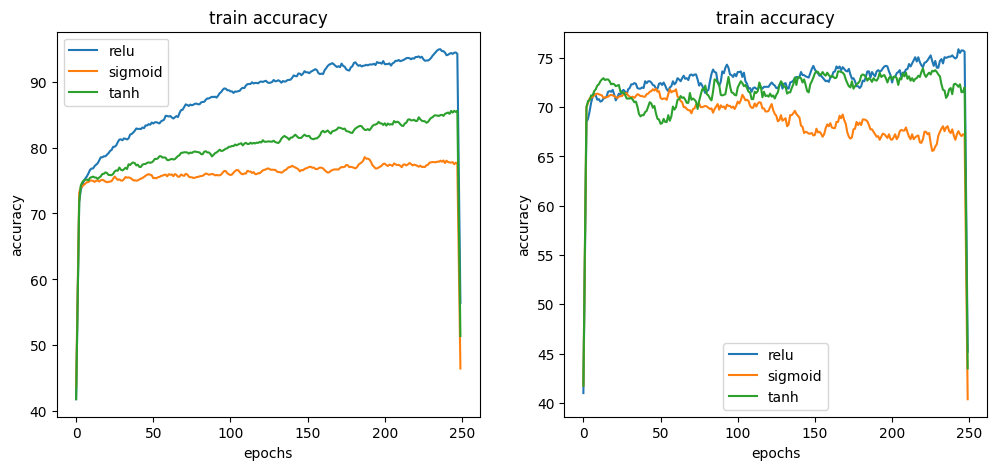

In [15]:
# plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs[0], label="relu")
plt.plot(train_accs[1], label="sigmoid")
plt.plot(train_accs[2], label="tanh")
plt.title("train accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accs[0], label="relu")
plt.plot(test_accs[1], label="sigmoid")
plt.plot(test_accs[2], label="tanh")
plt.title("train accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

plt.show()

In [12]:
# compare different veriations of relu
actFuns = ["ReLU", "ReLU6", "LeakyReLU"]
train_accs = []
test_accs = []
epochs = 250
for actFun in actFuns:
    model, optimizer, loss_fn = create_model(train_data.shape[1], 1, actFun)
    train_acc, test_acc = train_model(
        model, optimizer, loss_fn, train_loader, test_loader, epochs
    )
    train_accs.append(smooth(train_acc))
    test_accs.append(smooth(test_acc))
    print(f"completed {actFun}.")

completed ReLU.
completed ReLU6.
completed LeakyReLU.


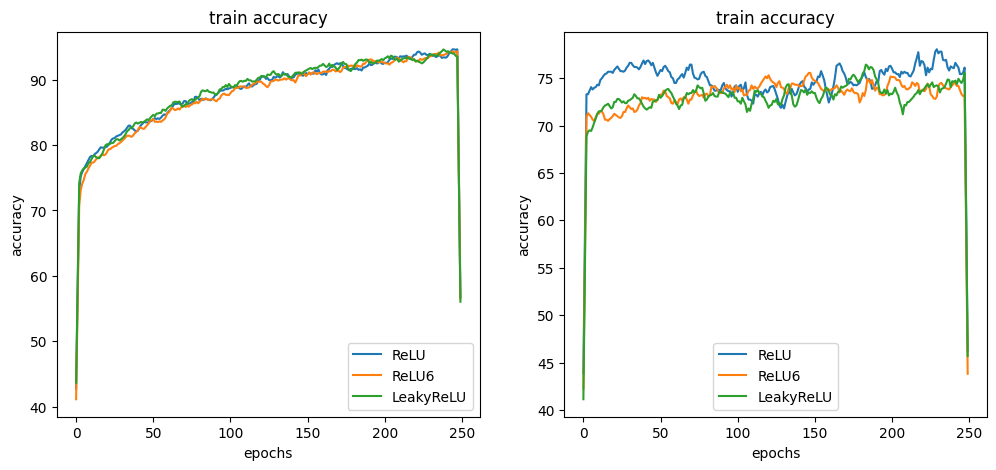

In [13]:
# plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs[0], label="ReLU")
plt.plot(train_accs[1], label="ReLU6")
plt.plot(train_accs[2], label="LeakyReLU")
plt.title("train accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accs[0], label="ReLU")
plt.plot(test_accs[1], label="ReLU6")
plt.plot(test_accs[2], label="LeakyReLU")
plt.title("train accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

plt.show()